In [1]:
from torchvision import models, datasets
import torch
import torchvision.transforms as T
from tqdm.notebook import tqdm

In [2]:
import sys
sys.path.insert(0, "./../")

In [3]:
from src.model import get_model_instance_segmentation
from src.test_utils import test_model_on_dataset, get_inference_time, get_model_prediction_one_image, get_model_size_mb
from src.references.detection import coco_utils
import src.references.detection.transforms as TL
from src.visual_utils import show_coco_dataset_item, show_instance_segmentation_by_model_predictions

In [4]:
COCO_ROOT_PATH = "/data"

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cpu_device = torch.device("cpu")
device = cpu_device
device

device(type='cpu')

### Load dataset

In [6]:
common_transforms = TL.Compose([TL.ToTensor()])

dataset = coco_utils.get_coco(COCO_ROOT_PATH, "val", common_transforms, dataset_len=200)

loading annotations into memory...
Done (t=0.68s)
creating index...
index created!


In [7]:
show_coco_dataset_item(dataset[5])

### Load model

In [8]:
model = get_model_instance_segmentation()

In [9]:
# https://pytorch.org/docs/stable/quantization.html
# https://discuss.pytorch.org/t/does-dynamic-quantization-support-gpu/119231

In [10]:
model = torch.quantization.quantize_dynamic(
    model,
    {torch.nn.Linear},
    dtype=torch.qint8
)

### Get memory

In [11]:
get_model_size_mb(model)

114.99625396728516

### Test inference on one image

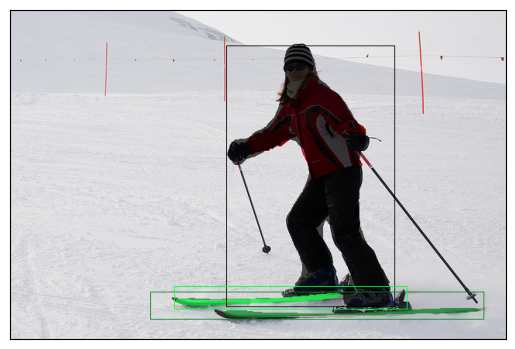

In [12]:
item_index = 5
img = dataset[item_index][0]
pred = get_model_prediction_one_image(img, model, device)
show_instance_segmentation_by_model_predictions(img, pred)

### Measure model performance

#### Metrics

In [12]:
test_model_on_dataset(model, dataset, device)

Test:  [  0/200]  eta: 0:45:08  model_time: 11.7600 (11.7600)  evaluator_time: 0.1366 (0.1366)  time: 13.5411  data: 0.0506  max mem: 0
Test:  [199/200]  eta: 0:00:12  model_time: 8.1447 (12.6491)  evaluator_time: 0.0372 (0.0833)  time: 8.4467  data: 0.0246  max mem: 0
Test: Total time: 0:42:36 (12.7808 s / it)
Averaged stats: model_time: 8.1447 (12.6491)  evaluator_time: 0.0372 (0.0833)
Accumulating evaluation results...
DONE (t=0.77s).
Accumulating evaluation results...
DONE (t=0.70s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.428
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.642
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.479
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.283
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.471
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.581
 Average R

In [14]:
test_model_on_dataset(model, dataset, device, cat_ids=[1]) # person

Test:  [  0/200]  eta: 0:36:16  model_time: 9.8311 (9.8311)  evaluator_time: 0.0889 (0.0889)  time: 10.8828  data: 0.0485  max mem: 0
Test:  [199/200]  eta: 0:00:08  model_time: 7.8767 (7.9374)  evaluator_time: 0.0275 (0.0395)  time: 8.4811  data: 0.0249  max mem: 0
Test: Total time: 0:26:41 (8.0065 s / it)
Averaged stats: model_time: 7.8767 (7.9374)  evaluator_time: 0.0275 (0.0395)
Accumulating evaluation results...
DONE (t=0.04s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.824
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.527
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.319
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.612
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.667
 Average Recall

#### Inference time

In [13]:
model = model.to(device)
model = model.eval()
total_time = 0
for i, dataset_item in tqdm(enumerate(dataset), total=len(dataset)):
    input_image = dataset_item[0]
    img = input_image.to(device)
    item_time = get_inference_time(img, model, device)
    total_time += item_time
print(f"Mean time: {total_time / len(dataset)}")

  0%|          | 0/200 [00:00<?, ?it/s]

Mean time: 3.1122985100746154
